## Introduction

This notebook is for the major project submission for COMP7220/8220, on the [image/language] dataset and task.  It contains the following sections:

*   a description of the selected conventional ML model;
*   some notes about the choices made in building the conventional ML model;
*   a description of the selected deep learning model;
*   some notes about the choices made in building the deep model; and
*   a discussion of the performance of the two models.


# Data preprocessing.

In [ ]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import keras
import pandas as pd
import numpy as np
from os.path import join

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [ ]:
image_size = 48
EMOTIONS = ['angry', 'disgusted', 'fearful','happy', 'sad', 'surprised', 'neutral']
dataset_directory = '/content/drive/My Drive/Colab Notebooks/major project/data'  ## CHANGE TO YOUR OWN DIRECTORY

images_train = np.load(join(dataset_directory, 'Training_data_images.npy'))
labels_train = np.load(join(dataset_directory, 'Training_data_labels.npy'))

images_test_public = np.load(join(dataset_directory, 'PublicTest_data_images.npy'))

images_train = images_train.reshape([-1, image_size, image_size])
images_test_public = images_test_public.reshape([-1, image_size, image_size])

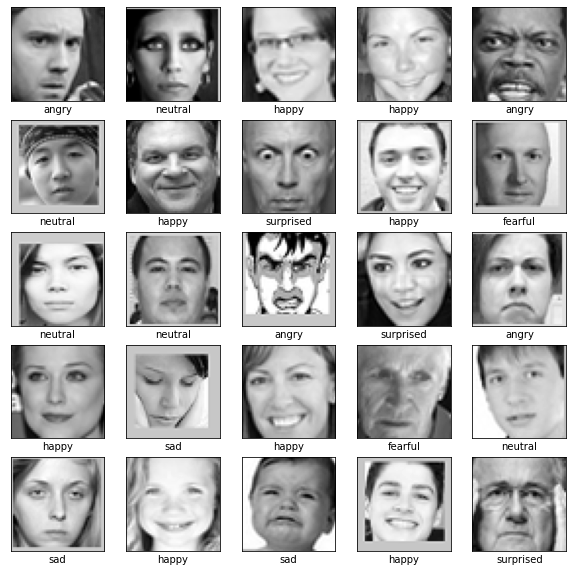

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train[i], cmap='gray')
    plt.xlabel( EMOTIONS[ labels_train[i] ] )
plt.show()

As we can see, the dataset contains 48x48 gray images. Next, we have to turn the dataset into features so models can learn form it. One of ways to do that is using histogram of oriented gradients (HOG). 

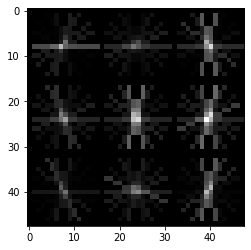

In [ ]:
from skimage.feature import hog
from skimage.color import rgb2grey
# run HOG using our greyscale bombus image
hog_features, hog_image = hog(images_train[1],
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

plt.imshow(hog_image, cmap=mpl.cm.gray)

In [ ]:
def create_features(img):
    # get HOG features from greyscale image
    hog_features = hog(img, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    return hog_features

features = create_features(images_train[1])
print(features)

[0.09859132 0.08504644 0.0901349  0.09334381 0.22406558 0.01664467
 0.00862433 0.0130857  0.04367972 0.02476077 0.06134126 0.06948938
 0.10141165 0.13514971 0.05614361 0.04691403 0.04250718 0.02347694
 0.22406558 0.01649935 0.01005163 0.04674967 0.14501243 0.05517446
 0.1480541  0.08820874 0.22406558 0.06083631 0.0460195  0.05004515
 0.10196528 0.12125297 0.07235055 0.05558484 0.13433447 0.1533297
 0.22406558 0.09371956 0.04681304 0.06172469 0.12464003 0.08025056
 0.11622697 0.12506653 0.22406558 0.22406558 0.13553563 0.06325603
 0.19460602 0.11924683 0.07781592 0.09380129 0.08450588 0.22406558
 0.07612562 0.02033858 0.01560029 0.00818157 0.07363107 0.01148802
 0.06435584 0.14759245 0.08240138 0.09208441 0.0413406  0.06846736
 0.09381385 0.10865823 0.17781992 0.04517725 0.07508203 0.05399452
 0.22406558 0.15356941 0.11794336 0.04215933 0.01409894 0.01838848
 0.03727853 0.02789626 0.22406558]


In [ ]:
def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img in label_dataframe:
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(images_train)
print(feature_matrix.shape)

(9328, 81)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_matrix, labels_train, test_size=.2,  shuffle=True, random_state=42)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

3    2182
6    1536
0    1014
2     888
5     839
4     826
1     177
dtype: int64

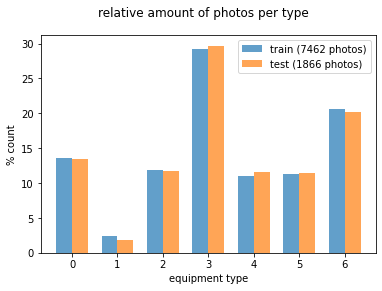

In [ ]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
 
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
 
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
 
    xtemp = np.arange(len(unique))
 
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)),
    'test ({0} photos)'.format(len(y_test))
]);

- Data look good enough to train our models.

# Conventional ML Model

First let's try some model that in my opinion are good for image classification:
- SVC.
- Logistic Regression.
- Naive Bayes.

In [ ]:
# Train and evaluate a SVC model
from sklearn.svm import SVC
svc = SVC().fit(X_train, y_train)
print('SVC classifier accuracy: %.4f\n' % svc.score(X_test, y_test))

#scaling the features for Logistic Regression classification
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0

# Train and evaluate a Logistic Regression classification model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_train_scaled, y_train)
print('Random Forest classifier accuracy: %.4f\n' % lr.score(X_test, y_test))

# Train and evaluate a Naive Bayes classification model
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB().fit(X_train, y_train)
print('Naive Bayes classifier accuracy: %.4f\n' % nb.score(X_test, y_test))

SVC classifier accuracy: 0.4962

Random Forest classifier accuracy: 0.2969

Naive Bayes classifier accuracy: 0.3692



Support vector classifier is the most promising model. Let's improve it by tuning parameters.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
svc = SVC()
grid = GridSearchCV(svc,param_grid, cv=5)
grid.fit(X_train,y_train)
print('The best kernel for SVC is: ', grid.best_params_['kernel'])
print('The best score is: ', grid.best_score_)

The best kernel for SVC is:  poly
The best score is:  0.4919581819716316


Now, we know the best kernel is "poly" we can further test parameters.

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['poly']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=poly .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.412, total=   7.2s
[CV] C=0.1, gamma=1, kernel=poly .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.421, total=   7.2s
[CV] C=0.1, gamma=1, kernel=poly .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.4s remaining:    0.0s


[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.411, total=   7.2s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.418, total=   7.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.417, total=   7.2s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.292, total=   7.1s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.292, total=   7.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.292, total=   7.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.293, total=   7.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 15.5min finished


{'C': 10, 'gamma': 1, 'kernel': 'poly'}
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


As result, we have best parameter for the model.
- (C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Now we train the model one more time to see if there is any improvement.

In [ ]:
# train the model on train set 
model = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
model.fit(X_train, y_train) 
  
# print prediction results 
predictions = model.predict(X_test) 
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.39      0.39      0.39       252
           1       0.58      0.32      0.42        34
           2       0.42      0.32      0.36       219
           3       0.60      0.73      0.66       554
           4       0.42      0.23      0.29       217
           5       0.58      0.55      0.57       213
           6       0.43      0.50      0.46       377

    accuracy                           0.50      1866
   macro avg       0.49      0.43      0.45      1866
weighted avg       0.49      0.50      0.49      1866



Conclusion:
- Despise tuned, conventional model in general still doing poorly in image classification. 
- The biggest reason is because those models are too simple to learn the data. 

# Deep Learning Model

The final model is CNN with 0.59595 accuracy on pulblic test set and 0.62012 on private set.
- The input was the raw data that had been convert to rgb demention.

- The network is not complex with 3 convolutional layers. Each include batch nomalize for nomalize input and drop out to prevent overfitting. Activation is relu for performace. Following are two normal fully connected layers.


In [ ]:
image_size = 48
EMOTIONS = ['angry', 'disgusted', 'fearful','happy', 'sad', 'surprised', 'neutral']
dataset_directory = '/content/drive/My Drive/Colab Notebooks/major project/data'  ## CHANGE TO YOUR OWN DIRECTORY

images_train = np.load(join(dataset_directory, 'Training_data_images.npy'))
labels_train = np.load(join(dataset_directory, 'Training_data_labels.npy'))


images_test_private = np.load(join(dataset_directory, 'PrivateTest_data_images.npy'))
images_test_public = np.load(join(dataset_directory, 'PublicTest_data_images.npy'))

images_train = images_train.reshape([images_train.shape[0], image_size, image_size, 1])
images_test_public = images_test_public.reshape([images_test_public.shape[0], image_size, image_size, 1])
images_test_private = images_test_private.reshape([images_test_private.shape[0], image_size, image_size, 1])

print(images_train.shape)
print(labels_train.shape)
print(images_test_public.shape)
print(images_test_private.shape)

(9328, 48, 48, 1)
(9328,)
(1136, 48, 48, 1)
(1153, 48, 48, 1)


In [ ]:
import random
data = []
for i in range(len(images_train)):
  data.append({'x':images_train[i], 'y':labels_train[i]})

random.shuffle(data)

In [ ]:
train_split, val_split = 0.7, 0.15
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [ ]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(x_train.shape)

(6529, 48, 48, 1)


In [ ]:
# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
y_test = keras.utils.to_categorical(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)


(6529, 7)
(1399, 7)
(1400, 7)


In [ ]:
# summary
print("finished loading %d images from %d categories"%(len(data), 7))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 9328 images from 7 categories
train / validation / test split: 6529, 1399, 1400
training data shape:  (6529, 48, 48, 1)
training labels shape:  (6529, 7)


In [ ]:
from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.utils import to_categorical

model = models.Sequential()
model.add(layers.Conv2D(64, (1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(layers.Conv2D(256, (5, 5),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2),padding="same"))
model.add(Dropout(0.25))


model.add(layers.Flatten())

model.add(layers.Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(layers.Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(layers.Dense(7, activation='softmax'))


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 48, 48, 64)        128       
_________________________________________________________________
batch_normalization_26 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
dropout_36 (Dropout)         (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 48, 48, 128)       73856     
_________________________________________________________________
batch_normalization_27 (Batc (None, 48, 48, 128)       512       
_________________________________________________________________
dropout_37 (Dropout)         (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 48, 48, 256)     

In [ ]:
# history = model.fit(X_train, y_train,
#                    validation_data=(X_test, y_test),
#                    class_weight = class_weight,
#                    epochs=15,
#                    batch_size=64)

# compile the model to use categorical cross-entropy loss function and adadelta optimizer
callback = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=15,
                    validation_data=(x_val, y_val),
                    callbacks = [callback])

Epoch 1/15
103/103 [==============================] - 10s 96ms/step - loss: 1.7739 - accuracy: 0.3507 - val_loss: 1.8456 - val_accuracy: 0.3374
Epoch 2/15
103/103 [==============================] - 10s 95ms/step - loss: 1.4379 - accuracy: 0.4705 - val_loss: 1.8536 - val_accuracy: 0.2974
Epoch 3/15
103/103 [==============================] - 10s 94ms/step - loss: 1.2718 - accuracy: 0.5358 - val_loss: 1.6856 - val_accuracy: 0.3903
Epoch 4/15
103/103 [==============================] - 10s 93ms/step - loss: 1.0932 - accuracy: 0.5967 - val_loss: 1.3457 - val_accuracy: 0.4996
Epoch 5/15
103/103 [==============================] - 9s 92ms/step - loss: 0.9327 - accuracy: 0.6561 - val_loss: 1.2223 - val_accuracy: 0.5554
Epoch 6/15
103/103 [==============================] - 9s 91ms/step - loss: 0.7714 - accuracy: 0.7261 - val_loss: 1.2712 - val_accuracy: 0.5690
Epoch 7/15
103/103 [==============================] - 9s 91ms/step - loss: 0.6396 - accuracy: 0.7721 - val_loss: 1.2189 - val_accuracy: 0.

In [ ]:
# visualise training and testing accuracy and loss

def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    


    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
 
# print best epoch with best accuracy on validation

def get_best_epcoh(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

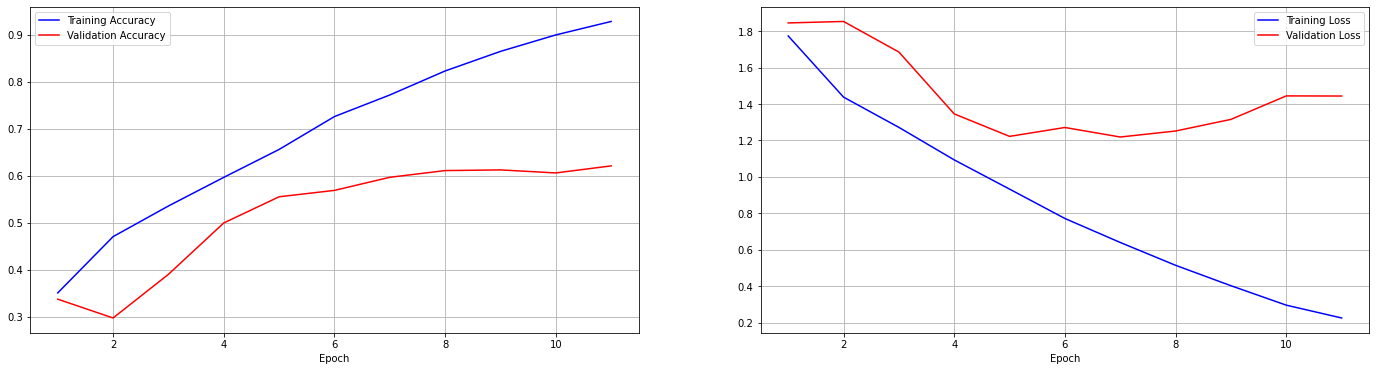

Best Validation Accuracy Score 0.62116, is for epoch 11


In [ ]:
plot_results(history)
best_epoch =get_best_epcoh(history)

In [ ]:
prediction = model.predict(images_test_public)
result = []
for i in range(len(prediction)):
  result.append(np.argmax(prediction[i]))

In [ ]:
df = pd.DataFrame(result,columns=['Predictions'])
df.reset_index(level=0, inplace=True)
df.columns = ['ID', 'Predictions']
df.to_csv('public_predictions_label.csv', index=False)

In [ ]:
prediction = model.predict(images_test_private)
result = []
for i in range(len(prediction)):
  result.append(np.argmax(prediction[i]))

In [ ]:
df = pd.DataFrame(result,columns=['Predictions'])
df.reset_index(level=0, inplace=True)
df.columns = ['ID', 'Predictions']
df.to_csv('private_predictions_label.csv', index=False)